In [ ]:
import os

os.chdir("/home/unix/SmartBinAnalysis/Deliverables")

## Working with extract interfaces

We start by dealing with Figueira da Foz Drivers information. We start by importing data from the CSV for pre-processing. We set "print_first_line" to true, to be able to be able to see the formats, and keys we will need to set as arguments for the pre-processing function. Running this will print the first line of each dataframe. Now, we use this information to infer date and headers formats and names to send to the pre-processing function.

Be aware that some csv's have a different separation. For instance, the Figueira da Foz one uses ';' instead of ','

In [ ]:
import extract as e

PATH = "/mnt/c/Users/Utilizador/OneDriveUL/Desktop/Masters/Wsmart+Route/Dados_atualizados/"
FILE = 'Enchimentos_com_Recolhas[FigFoz].csv'

fill_df, rec_df = e.import_same_file(FILE,
                                    collect_id_header = "idrecolha",
                                    sep               = ';', 
                                    path              = PATH, 
                                    print_first_line  = True)

FILL DF LINE 1: 
idcontentor                                      13819
Matricula do contentor                            1288
Tipo de contentor                            Roto 2500
Volume do tipo de contentor                       2500
description                      Mistura de embalagens
Distrito                                       COIMBRA
Concelho                               FIGUEIRA DA FOZ
Freguesia                         Buarcos e São Julião
Localidade                                       F.Foz
Latitude                                     40.148842
Longitude                                    -8.850342
Data da leitura                2020-05-01 23:06:28.000
Enchimento                                          75
idrecolha                                          NaN
Rota                                               NaN
Data de ínicio                                     NaN
Data de fim                                        NaN
Km totais                                       

We use the the headers and formats provided by the information printed in the last run. Notice that the import function, limits itself to import the data to csv in a friendly way, adn splitting information in order for it to be included in the data structures we are using.

The pre-processing function accepts dataframes with many different columns. All it is interested is in extracting the relevant information from the collection and fill dataframes, take care of datatypes and renames headers that will be used throughout the rest of the code. Notice that all the code relies on this renaming, so all is required is to have separate tables with fill and collection information that the functions recognizes by user providing the subsequent headers. See the documentation for explanation of each required header.

All the information that is not collections or fill information is assumed not to be temporal dependant and just the first line is dumped into the info structure. This means information about location and trash type are are by default.


In [ ]:
fill, collect, info = e.pre_process_data(
                                    df_fill             = fill_df, 
                                    df_collection       = rec_df,
                                    id_header_fill      = "idcontentor",
                                    date_header_fill    = "Data da leitura",
                                    date_format_fill    = "%Y-%m-%d %H:%M:%S.%f",
                                    fill_header_fill    = "Enchimento",
                                    id_header_collect   = "idcontentor",
                                    date_header_collect = "Data da leitura",
                                    date_format_collect = "%Y-%m-%d %H:%M:%S.%f",
                                )

Now, we treat each container in a independent manner. every time we manipulate the data of a container we "wrap" it under the Container class that transforms the data in a specialized data structure to handle plotting and  add the containers manipulation (prediction is done separately). Notice that we the wrapper assumes that the containers haven't been manipulated and call the initial pre-processing function to enable ploting and right away crude rate extraction.

By calling the wrapper, the dataframes are split fro each container and returned in a friendly dictionary organizes by dictionary ids.

To use the save and load interface further is useful to have a ready available list of ids and so the container_global_function also takes care fo that

In [3]:
container_dict, ids = e.container_global_sorted_wrapper(fill,collect, info)

### Handling Container Operations fro Drivers Data

Now there are already some things we can do if we are not interested in making corrections to the data. For instance we can plot the data. the plot function accepts dates has datetime objects already, but one can be lazy and pass on a a string the required format that the translation will happen seamlessly

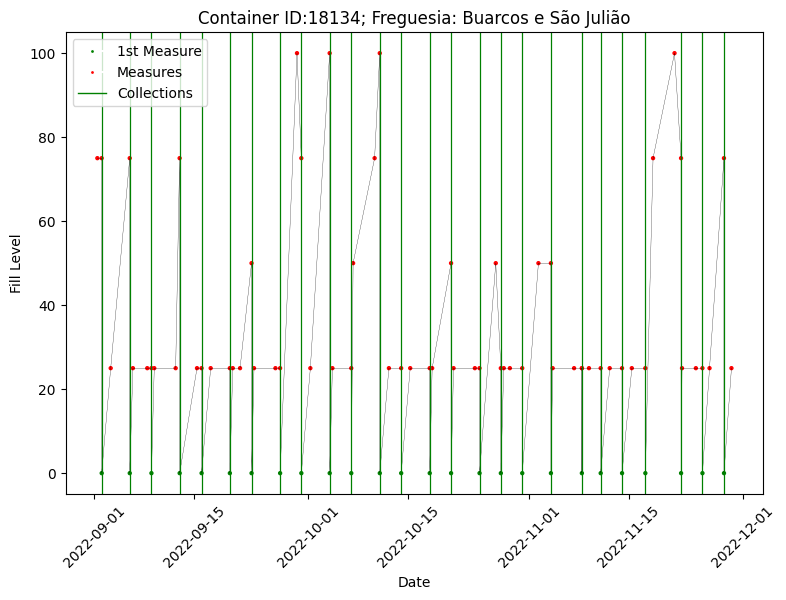

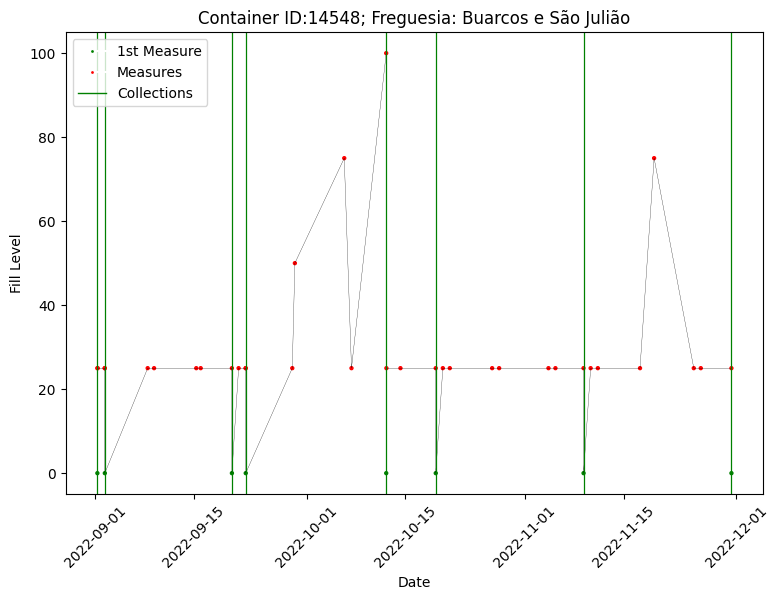

In [4]:
import random
from datetime import datetime

from Container import Container

start_date = "01-09-2022"
end_date = datetime(year=2022, month=12, day=1)

container:Container # type annotation

# my_ids = random.sample(ids, 2)
my_ids = [18134, 14548]

for id in my_ids:
    container = container_dict[id]
    container.plot_fill(start_date=start_date, end_date=end_date)

We we start by evaluating the quality of the data. Generally drivers data has collection that are well aligned with the readings because a collection is marked in the same way has a the fill level information is retrieved, so correcting collections is not mandatory. Nonetheless, has we can see on container 14548 the is what I call "difference of opinion" most commonly said to be "human error". when the difference between opinions is of *25* is does not bother, because after all we can assume teh container was tih a fill level in the middle point between the readings. Nonetheless, differences bigger than that are bit more difficult to explain and can happen seldom. 

If we want to do crude sampling on the rates, we might not want allow for the next driver to measure a value that is less than previous one because then the rates will be negative. nonetheless allow the rates to be negative we are not taking away any statistical significance from the data. If we atn to deal with it right away, we can compute **monotonical** approximations called *max* and *min*. The *max* approximation is an approximation from above. Basically it says the driver that puts in the higher value is right, so, if the next driver says that the container had less trash, we correct its estimation to the one fo the previous driver. the *min* approximation does the exact opposite. It assumes that the right value is lower one. Do, I a the next drive estimate a lower value, it corrects the measurement of the previous one to its value.

These monotonic approximation lead to very different results If we calculate the total trash collected in the end, they lead to about 20% difference. 

A way to avoid it is to compute the mean monotonic approximation that is the average between both approximations in each data point.

We start by computing the approximations

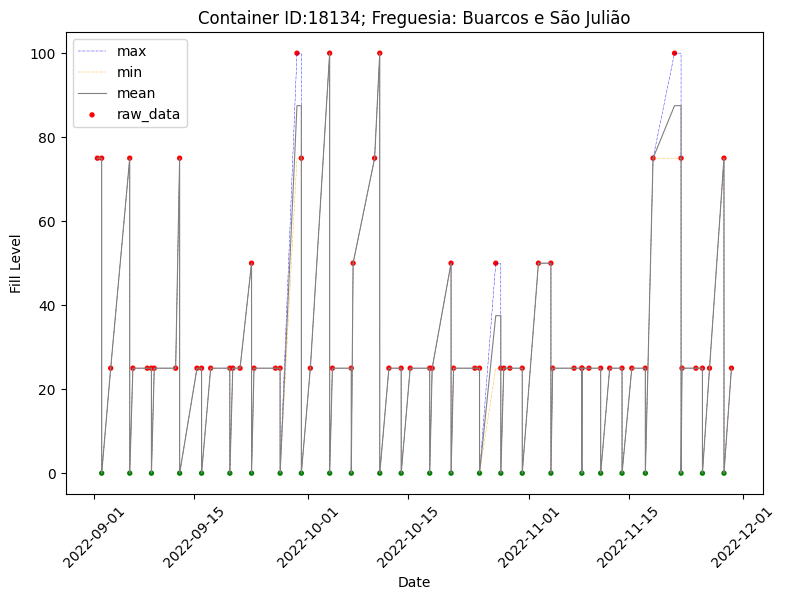

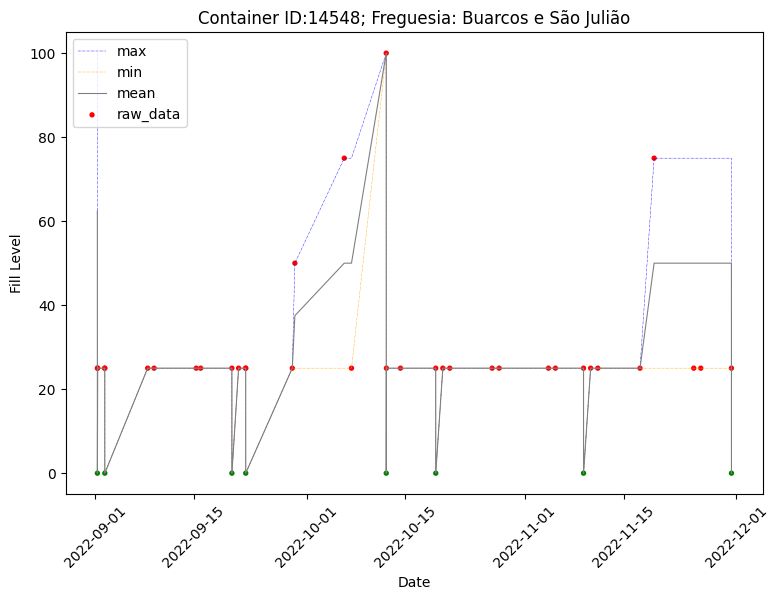

In [5]:
container:Container

for id in my_ids:
    container = container_dict[id]
    container.calc_max_min_mean()
    container.plot_max_min(start_date=start_date, end_date=end_date)

By analyzing the figures above we can see that the mean approximation makes a coherent estimation and is guaranteed to be monotonic. It is also obvious in the figure that the average distance between the max and min approximations is a good metric to identify data quality.

If we want o compute all the metrics right away for all the bins we can import the transform layer and call the metrics wrapper. This computes average distances and  the spearman correlation for all containers. We plot the distance for the results above just to start to get a meaning for the meaning of the metrics. Notice that for driver's data, the spearman correlation wont be able to be computed due to the input being constant. if this happens, I hav a try statement in the code that promptly sets this value to zero. Note that calculating these metrics is computationally heavy and so you might not want to have to need to run all of these things again. Don't worry because I got you covered below.

In the code snippet below I resort to calc functions of the class to calculate only average distance. The plot function has try statements around the dataframe keys so that it does not plot undefined quantities.

In [ ]:
container:Container # type annotation

for _, container in container_dict.items():
    container.calc_max_min_mean()
    container.calc_avg_dist_metric()

container:Container

for id in my_ids:
    container = container_dict[id]
    container.plot_collection_metrics(start_date=start_date, end_date=end_date)

Notice that the metrics are lower precisely on the points that we are less sure of what is happening. To check the state of the entire list of bins one can call the function below that extract and normalizes the data for analysis. This can be a good tool to visualize the two handcraft parameters for bins corrections.

In order to avoid the loops, all the metrics can be calculated with the help of the wrapper below, that takes care of everything for you. running *t.pre_process_container_metrics* takes about 3-4 min on my machine. It will lead to lots of warnings with driver's data because sometimes we get only a few datapoints within drivers and a pearson correletaion needs some data to work.

In order to visualize the data quality of the data, we can resort the view metrics function. Play around a little with the parameters to see what happens. Just a few tips:
 - Average Distance threshold should be lower than 75 because drivers difference of opinion of 25 is reasonable. (You will se this is also about the sensor's oscillations magnitude)
 - The Spearman correlation only works well when having lots of data. For drivers it leads to bad interpretations.
 - Use Avg_Dist for tagging with drivers and spearman for sensors
 - The 7 day window was empirically determined to be the most suitable for box identification. Resort to the documentation to see how tagging works


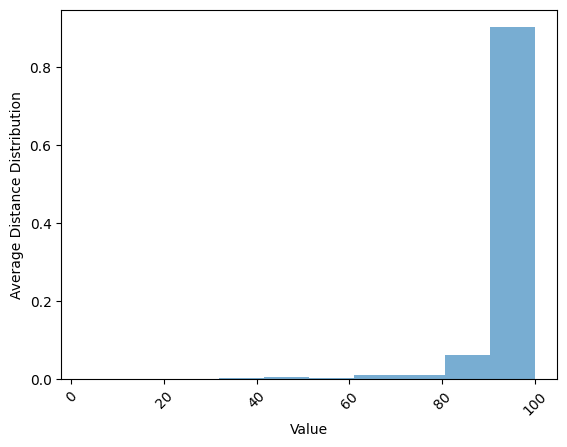

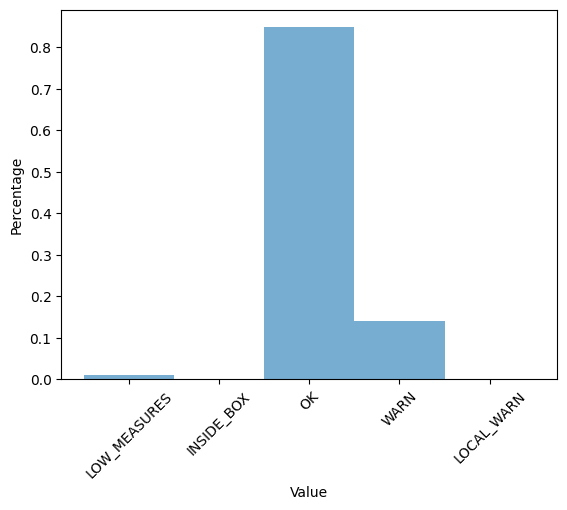

In [7]:
import transform as t

t.view_metrics(container_dict, box_window=7, mv_thresh = 70, min_days = 30, use = 'avg_dist')

We got ourselfs an overall perspective of the data quality of our data. We can see that more than 80% percent of our containers have a good data quality, and looking at the overall histogram, the values agree very well with what we expect that is an *Avg_Dist* of 100, that mean mean perfect alignement. 

### Wokting with loading and saving tools

Before we proceed to extrapolations on how to correct this data, notice that we lost sometimes to load and process the containers. So, there is some built-in support to save the data has you and load it easily to the same data structures in order to allow for seamless work. these tools are present in the save_load module

In [8]:
import save_load as sl

PATH = "home/unix/SmartBins_data"

sl.save_id_containers(ids, path=PATH)

container:Container
for id, container in container_dict.items():
    sl.save_container_structured(id, container, path=PATH)

